In [2]:
LIST_LOCATION = './data/lists4nodes.txt'
RESULTS_LOCATION = './data/results4nodes.txt'

In [3]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

2023-03-14 09:53:40.001489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 09:53:40.503181: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-14 09:53:40.503236: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-14 09:53:41.976564: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [5]:
np.set_printoptions(precision=3, suppress=True)
normalizer = tf.keras.layers.Normalization(axis=-1)

def preprocess():
    data = []
    results = []

    with open(LIST_LOCATION) as listFile:
        with open(RESULTS_LOCATION) as resFile:
            for lis, res in zip(listFile,resFile):
                intList = list(map(int, lis[:-1].split(',')))

                results.append(int(res[:-1]))
                data.append(intList)

    return pd.DataFrame(data), pd.DataFrame(results)

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)



In [6]:
data, res = preprocess()


dat_trn, dat_tst, res_trn, res_tst = train_test_split(data, res, test_size=0.2)

normalizer.adapt(dat_trn)

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


FileNotFoundError: [Errno 2] No such file or directory: './data/lists4nodes.txt'

In [ ]:
# Take data in 20% increments
for i in range(2, 10, 2):
    _ , data_slice, _, result_slice = train_test_split(data, res, test_size = i/10)
    dat_trn, dat_tst, res_trn, res_tst = train_test_split(data_slice, result_slice, test_size=0.2)
    history = dnn_model.fit(
        dat_trn,
        res_trn,
        validation_split=0.2,
        verbose=0, epochs=100)
    dnn_model.evaluate(dat_tst, dat_tst, verbose=0)

In [5]:
history = dnn_model.fit(
    dat_trn,
    res_trn,
    validation_split=0.2,
    verbose=0, epochs=100)

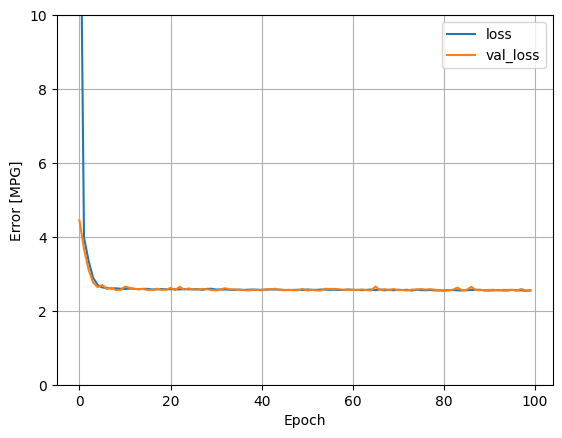

In [6]:
plot_loss(history)

In [7]:
dnn_model.evaluate(dat_tst, dat_tst, verbose=0)

17.50090789794922

50/50 [==============================] - 0s 1ms/step


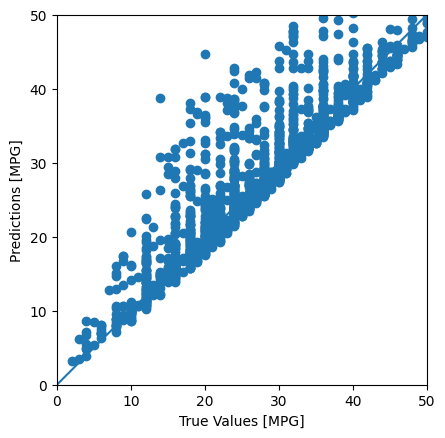

In [8]:
test_predictions = dnn_model.predict(dat_tst).flatten()

a = plt.axes(aspect='equal')
plt.scatter(res_tst.T, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

       2215      2582      1662       3027      4343      2680      1765  \
0 -3.000908 -7.810105 -13.10174  49.670529 -1.227964 -2.552977 -0.090921   

       1123      4054      3761  ...     4993       231       1941      6880  \
0 -6.377342  1.783279  0.462002  ... -1.06917  88.276688  0.751912 -2.526361   

      7241      1079       7979       1115      6093      6832  
0 -5.30588 -3.217248  31.201944  74.112214 -4.016387 -0.852477  

[1 rows x 1600 columns]


Text(0, 0.5, 'Count')

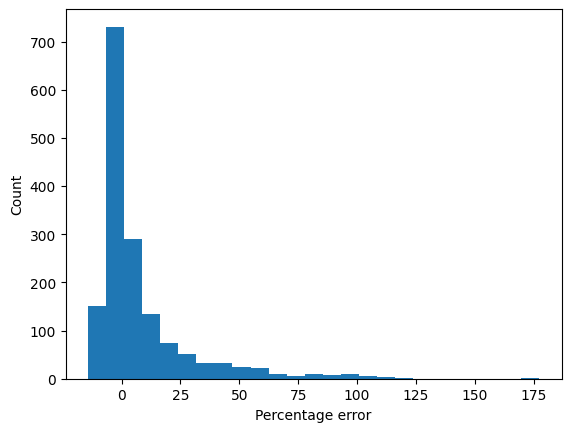

In [15]:
error = (100 * (test_predictions - res_tst.T)) / res_tst.T
print(error)

plt.hist(error.T, bins=25)
plt.xlabel('Percentage error')
plt.ylabel('Count')

In [10]:
# Get the absolute error
error.T.sum() / 1600

0    1.428409
dtype: float64